# Classifying sequences using sequence metadata

Same as `model.ipynb` but using CatBoost.

## Data loading and processing

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pydicom
import nltk
from glob import glob
from io import StringIO
from copy import deepcopy

from src.msc.constants import *
from src.msc.sanitization import *
from src.msc.feature_extraction import *

data_path = "data/data_train.csv"
data = pd.read_csv(data_path)

data.loc[data["class"] == "DCE","class"] = "dce"
data = sanitize_data(data)

study_uids = np.array(data["study_uid"].tolist())
y = np.array(data["class"])

data = sequence_to_other_df(
    data,"study_uid","class","dwi","adc","percent_phase_field_of_view")
data = sequence_to_other_df(
    data,"study_uid","class","dwi","adc","sar")

X = data.drop(cols_to_drop,axis=1)

study_uids = np.array(data["study_uid"].tolist())
y = np.array(data["class"])

## Training

### CV performance

In [2]:
from catboost import CatBoostClassifier, FeaturesData, Pool
from sklearn.metrics import roc_auc_score,classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler,MinMaxScaler

n_folds = 5

kf = KFold(n_folds,shuffle=True,random_state=42)

nan_remover = RemoveNan()
unique_study_uids = list(set(study_uids))

f = 0

fold_results = []

model_dict = {
    "catboost":{
        "model":CatBoostClassifier,
        "params":{"devices":"0-4","verbose":False},
        "cv_params":{}
    }
}

model_name = "catboost"

for train_idxs,val_idxs in kf.split(unique_study_uids):
    print("Fold {}".format(f+1))
    # data splitting
    train_uids = [unique_study_uids[i] for i in train_idxs]
    val_uids = [unique_study_uids[i] for i in val_idxs]
    train_idxs_long = [i for i,x in enumerate(study_uids) 
                       if x in train_uids]
    val_idxs_long = [i for i,x in enumerate(study_uids) 
                     if x in val_uids]
    training_X = X.iloc[train_idxs_long]
    training_y = y[train_idxs_long]
    val_X = X.iloc[val_idxs_long]
    val_y = y[val_idxs_long]

    print("\tTransforming data")
    cat_feature_cols = text_sep_cols + num_sep_cols
    fc = [x for x in training_X.columns if x in cat_feature_cols]
    training_data = Pool(
        data=FeaturesData(
            cat_feature_data=np.array(training_X[fc]),
            num_feature_data=np.array(training_X[num_cols],dtype=np.float32)),
        label=np.array(training_y))
    val_data = Pool(
        data=FeaturesData(
            cat_feature_data=np.array(val_X[fc]),
            num_feature_data=np.array(val_X[num_cols],dtype=np.float32)),
        label=val_y)

    print("\tTraining model")
    md = model_dict

    search_fn = GridSearchCV

    model = md[model_name]["model"](**model_dict[model_name]["params"])

    model.fit(training_data)

    print("\tEvaluating model")
    y_pred = model.predict(val_data)
    fold_results.append({
        "auc":roc_auc_score(val_y,model.predict_proba(val_data),
                            multi_class="ovr"),
        "model":model,
        "y_true":val_y,
        "y_pred":y_pred,
        })
    
    f += 1

Fold 1
	Transforming data
	Training model
	Evaluating model
              precision    recall  f1-score   support

         adc       1.00      0.98      0.99      1044
         dce       0.98      0.99      0.98       801
         dwi       0.99      0.99      0.99      1550
      others       0.99      0.99      0.99      2062
          t2       0.99      0.99      0.99      1153

    accuracy                           0.99      6610
   macro avg       0.99      0.99      0.99      6610
weighted avg       0.99      0.99      0.99      6610

Fold 2
	Transforming data
	Training model
	Evaluating model
              precision    recall  f1-score   support

         adc       1.00      1.00      1.00       997
         dce       1.00      1.00      1.00       513
         dwi       0.99      1.00      1.00      1474
      others       0.99      1.00      0.99      1819
          t2       1.00      0.99      0.99      1132

    accuracy                           1.00      5935
   macro av

[0.9996     0.99960735 0.99978613 0.99986657 0.99987036]


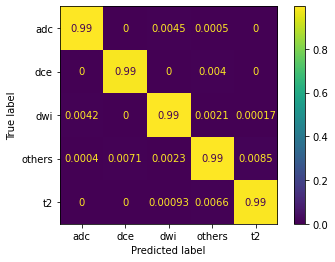

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cms = []
aucs = []
for f in fold_results:
    aucs.append(f["auc"])
    cm = confusion_matrix(f["y_true"],f["y_pred"])
    
    cm = cm / cm.sum(1)
    cms.append(cm)

print(np.quantile(aucs,[0,0.05,0.5,0.95,1.0]))
ConfusionMatrixDisplay(np.array(cms).mean(0),display_labels=f["model"].classes_).plot()
plt.show()

In [12]:
metric_dict = {"metric":[],"fold":[],"sequence_id":[],"value":[]}
for i,f in enumerate(fold_results):
    cr = classification_report(
        f["y_true"],f["y_pred"],
        output_dict=True)
    for k in cr:
        if isinstance(cr[k],dict):
            for kk in cr[k]:
                metric_dict["sequence_id"].append(k.upper())
                metric_dict["value"].append(cr[k][kk])
                metric_dict["metric"].append(kk)
                metric_dict["fold"].append(i)

metric_df = pd.DataFrame.from_dict(metric_dict)
metric_df

,metric,fold,sequence_id,value
0,precision,0,ADC,0.995155
1,recall,0,ADC,0.983716
2,f1-score,0,ADC,0.989403
3,support,0,ADC,1044.000000
4,precision,0,DCE,0.976658
...,...,...,...,...
135,support,4,MACRO AVG,6142.000000
136,precision,4,WEIGHTED AVG,0.990899
137,recall,4,WEIGHTED AVG,0.990882
138,f1-score,4,WEIGHTED AVG,0.990884


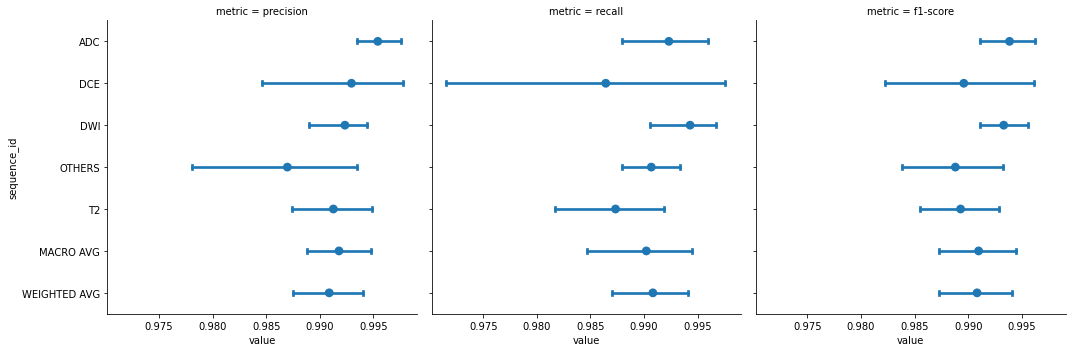

In [13]:
import seaborn as sb

metric_df["idx"] = np.arange(metric_df.shape[0])
metric_df.pivot(["metric","fold"],"sequence_id","value").reset_index()

sb.catplot(data=metric_df[metric_df["metric"]!="support"],y="sequence_id",x="value",
           kind="point",col="metric",join=False,capsize=.1)

### Hold-out test set

In [14]:
test_data_path = "data/data_test.csv"
data_hold_out = pd.read_csv(test_data_path)
data_hold_out.loc[data_hold_out["class"] == "DCE","class"] = "dce"

data_hold_out = sanitize_data(data_hold_out)
data_hold_out = sequence_to_other_df(
    data_hold_out,"study_uid","class","dwi","adc","percent_phase_field_of_view")
data_hold_out = sequence_to_other_df(
    data_hold_out,"study_uid","class","dwi","adc","sar")

X_hold_out = data_hold_out.drop(cols_to_drop,axis=1)
y_hold_out = np.array(data_hold_out["class"])

In [15]:
all_predictions = {}

for i,f in enumerate(fold_results):
    model = f["model"]
    test_data_pred = Pool(
        data=FeaturesData(
            cat_feature_data=np.array(X_hold_out[fc]),
            num_feature_data=np.array(X_hold_out[num_cols],dtype=np.float32)),
        label=y_hold_out)

    y_pred = model.predict(test_data_pred)

    all_predictions[i] = {"true":test_data_pred.get_label(),"pred":y_pred}

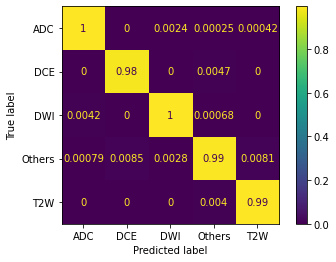

In [16]:
cms = []
l = ["ADC","DCE","DWI","Others","T2W"]
for i in all_predictions:
    f = all_predictions[i]
    cm = confusion_matrix(f["true"],f["pred"])
    
    cm = cm / cm.sum(1)
    cms.append(cm)

ConfusionMatrixDisplay(np.array(cms).mean(0),display_labels=l).plot()
plt.show()

In [17]:
hold_out_metric_dict = {"metric":[],"fold":[],"sequence_id":[],"value":[]}
for i in all_predictions:
    cr = classification_report(all_predictions[i]["true"],
                               all_predictions[i]["pred"],
                               output_dict=True)
    for k in cr:
        if isinstance(cr[k],dict):
            for kk in cr[k]:
                hold_out_metric_dict["sequence_id"].append(k.upper())
                hold_out_metric_dict["value"].append(cr[k][kk])
                hold_out_metric_dict["metric"].append(kk)
                hold_out_metric_dict["fold"].append(i)

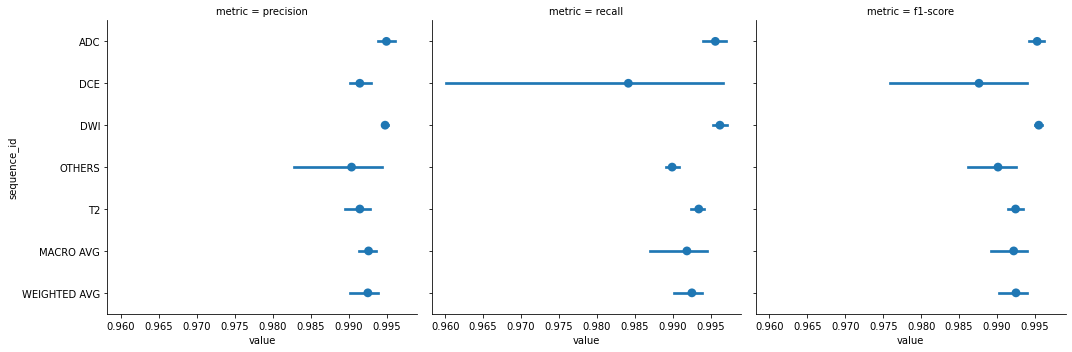

In [10]:
hold_out_metric_df = pd.DataFrame.from_dict(hold_out_metric_dict)

hold_out_metric_df["idx"] = np.arange(hold_out_metric_df.shape[0])
hold_out_metric_df.pivot(["metric","fold"],"sequence_id","value").reset_index()

sb.catplot(data=hold_out_metric_df[hold_out_metric_df["metric"]!="support"],y="sequence_id",x="value",
           kind="point",col="metric",join=False)